In [3]:
library('fpp3')
library('ggplot2')

Uma limitação dos modelos que consideramos até agora é que eles impõem uma relação unidirecional, a variável de previsão é influenciada pelas variáveis preditoras, mas não vice-versa.


Contudo, há muitos casos em que o inverso também deveria ser permitido, onde todas as variáveis se afetam umas às outras. Por exemplo, o dataset `us_change` possui as variações nas despesas de consumo pessoal (Ct) e as variações do rendimento disponível pessoal (It). Contudo, neste caso, uma relação bidirecional pode ser mais adequada, um aumento em It levará a um aumento em Ct e vice-versa.


Presume-se que cada variável influencia todas as outras variáveis do sistema, o que torna difícil uma interpretação direta dos coeficientes estimados. Apesar disso, os VAR são úteis em vários contextos:


1. Prever uma coleção de variáveis relacionadas onde nenhuma interpretação explícita é necessária;
2. Testar se uma variável é útil na previsão de outra (a base dos testes de causalidade de Granger);
3. Análise de resposta ao impulso, onde é analisada a resposta de uma variável a uma mudança repentina, mas temporária, em outra variável;
5. Decomposição da variância do erro de previsão, onde a proporção da variância da previsão de cada variável é atribuída aos efeitos das demais variáveis.


Um exemplo dessa mesma situação ocorreu na Austrália durante a crise financeira global de 2008 a 2009. O governo australiano emitiu pacotes de estímulo que incluíam pagamentos em dinheiro em Dezembro de 2008, mesmo a tempo das despesas de Natal. Como resultado, os retalhistas reportaram fortes vendas e a economia foi estimulada. Consequentemente, os rendimentos aumentaram.


Tais relações de feedback são permitidas na estrutura vetorial autorregressiva (VAR). Nesta estrutura todas as variáveis são tratadas simetricamente. Todos eles são modelados como se todos influenciaram uns aos outros igualmente. Numa terminologia mais formal, todas as variáveis são agora tratadas como "endógenas" ou variáveis alvo. Para significar isso, agora mudamos a notação e escrevemos todas as variáveis como:


$ys: y_{1,t}$ denota a "$t$ th" observação, ou a observação alguma observação em $t$ das variáveis $y_1$.


$y_{2,t}$ denota a "$t$ th" observação da variável $y_{2,t}$ e assim sucessivamente.


Se as séries forem estacionárias, nós as previmos ajustando um VAR diretamente aos dados (conhecido como "VAR em níveis"). Se as séries forem não estacionárias, pegamos as diferenças dos dados para torná-los estacionários e, em seguida, ajustamos um modelo VAR (conhecido como "VAR em diferenças"). Em ambos os casos, os modelos são estimados equação por equação utilizando o princípio dos mínimos quadrados. Para cada equação, os parâmetros são estimados minimizando a soma dos valores quadrados de $\varepsilon_{i,t}$.


Um modelo VAR é uma generalização do modelo autoregressivo univariado para previsão de um vetor de séries temporais. Compreende uma equação por variável no sistema. O lado direito de cada equação inclui uma constante e defasagens de todas as variáveis do sistema. Para simplificar, consideramos um VAR de duas variáveis com uma defasagem. Escrevemos um modelo VAR(1) bidimensional como:


\begin{align}
 y_{1,t} = c_1+\phi _{11,1}y_{1,t-1}+\phi _{12,1}y_{2,t-1}+\varepsilon_{1,t} \\
 y_{2,t} = c_2+\phi _{21,1}y_{1,t-1}+\phi _{22,1}y_{2,t-1}+\varepsilon_{2,t}
\end{align}


As previsões do modelo VAR consiste de uma forma recursiva e ele também irá gerar as previsões para cada variável incluída, no exemplo abaixo é um modelo VAR(1) com duas variáveis e a equação descreve a previsão em h-step a frente e em até T, todas baseadas na equação (1) e na equação (2).


\begin{align*}
 \hat y_{1,T+1|T} &=\hat{c}_1+\hat\phi_{11,1}y_{1,T}+\hat\phi_{12,1}y_{2,T} \\
 \hat y_{2,T+1|T} &=\hat{c}_2+\hat\phi _{21,1}y_{1,T}+\hat\phi_{22,1}y_{2,T}
\end{align*}


Recursivamente, as próximas previsões, por exemplo para 2-step dependem das primeiras previsões como está na seguinte fórmula:


\begin{align*}
 \hat y_{1,T+2|T} &=\hat{c}_1+\hat\phi_{11,1}\hat y_{1,T+1|T}+\hat\phi_{12,1}\hat y_{2,T+1|T}\\
 \hat y_{2,T+2|T}&=\hat{c}_2+\hat\phi_{21,1}\hat y_{1,T+1|T}+\hat\phi_{22,1}\hat y_{2,T+1|T}.
\end{align*}


Existem mais duas decisões a serem feitas quando utilizamos os modelos VAR, a primeira é quantas variáveis utilizar, denotado por: $K$ e quantos lags, denotado por $p$ deverão ser incluídos.


Na prática, deixamos sempre o $K$ pequeno e incluímos apenas as variáveis que são correlacionadas umas com as outras e o critério de informação (AIC) é utilizado (às vezes) para selecionar o número de lags. Deve-se ter cuidado ao usar o AICc, pois ele tende a escolher um grande número de lags; em vez disso, para modelos VAR, geralmente usamos o BIC.


Uma versão mais sofisticada do modelo VAR é o "VAR esparso" (Sparse VAR) onde muitos coeficientes são definidos como zero, outra abordagem é usar "estimativa de redução" (shrinkage estimation) onde os coeficientes são menores.


### 1.0. Us Consumption

In [4]:
df = read.csv("../data/us_change.csv", header=TRUE, sep=",", stringsAsFactors=FALSE)
df = df |> select(Quarter, Consumption, Income, Production, Savings, Unemployment)
df$Quarter = yearquarter(df$Quarter)

df = df |> as_tsibble(index=Quarter)

head(df)

Quarter,Consumption,Income,Production,Savings,Unemployment
<qtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1970 Q1,0.6185664,1.0448013,-2.4524855,5.299014,0.9
1970 Q2,0.4519840,1.2256472,-0.5514595,7.789894,0.5
1970 Q3,0.8728718,1.5851538,-0.3586518,7.403984,0.5
1970 Q4,-0.2718479,-0.2395449,-2.1856909,1.169898,0.7
1971 Q1,1.9013450,1.9759249,1.9097644,3.535667,-0.1
1971 Q2,0.9148773,1.4459085,0.9015695,5.874764,-0.1


In [5]:
fit = us_change |>
    model(
        aicc=VAR(vars(Consumption, Income)),
        bic=VAR(vars(Consumption, Income), ic="bic")
    )

Usando o AICc obtemos um modelo VAR(5), já pelo BIC obtemos um modelo VAR(1). BIC sempre seleciona modelos com poucos parâmetros do que o AICc.

In [6]:
fit

aicc,bic
<model>,<model>
<VAR(5) w/ mean>,<VAR(1) w/ mean>


In [7]:
glance(fit)

.model,sigma2,log_lik,AIC,AICc,BIC
<chr>,<list>,<dbl>,<dbl>,<dbl>,<dbl>
aicc,"0.3195267, 0.1391537, 0.1391537, 0.6354455",-372.8583,797.7166,806.1744,882.5465
bic,"0.3601181, 0.1969693, 0.1969693, 0.7250800",-407.9293,835.8586,837.0414,868.6907


Podemos observar que os resíduos do modelo VAR(1) estão levemente correlacionados nos gráficos ACF, já para o AICc aparentemente é white noise. 

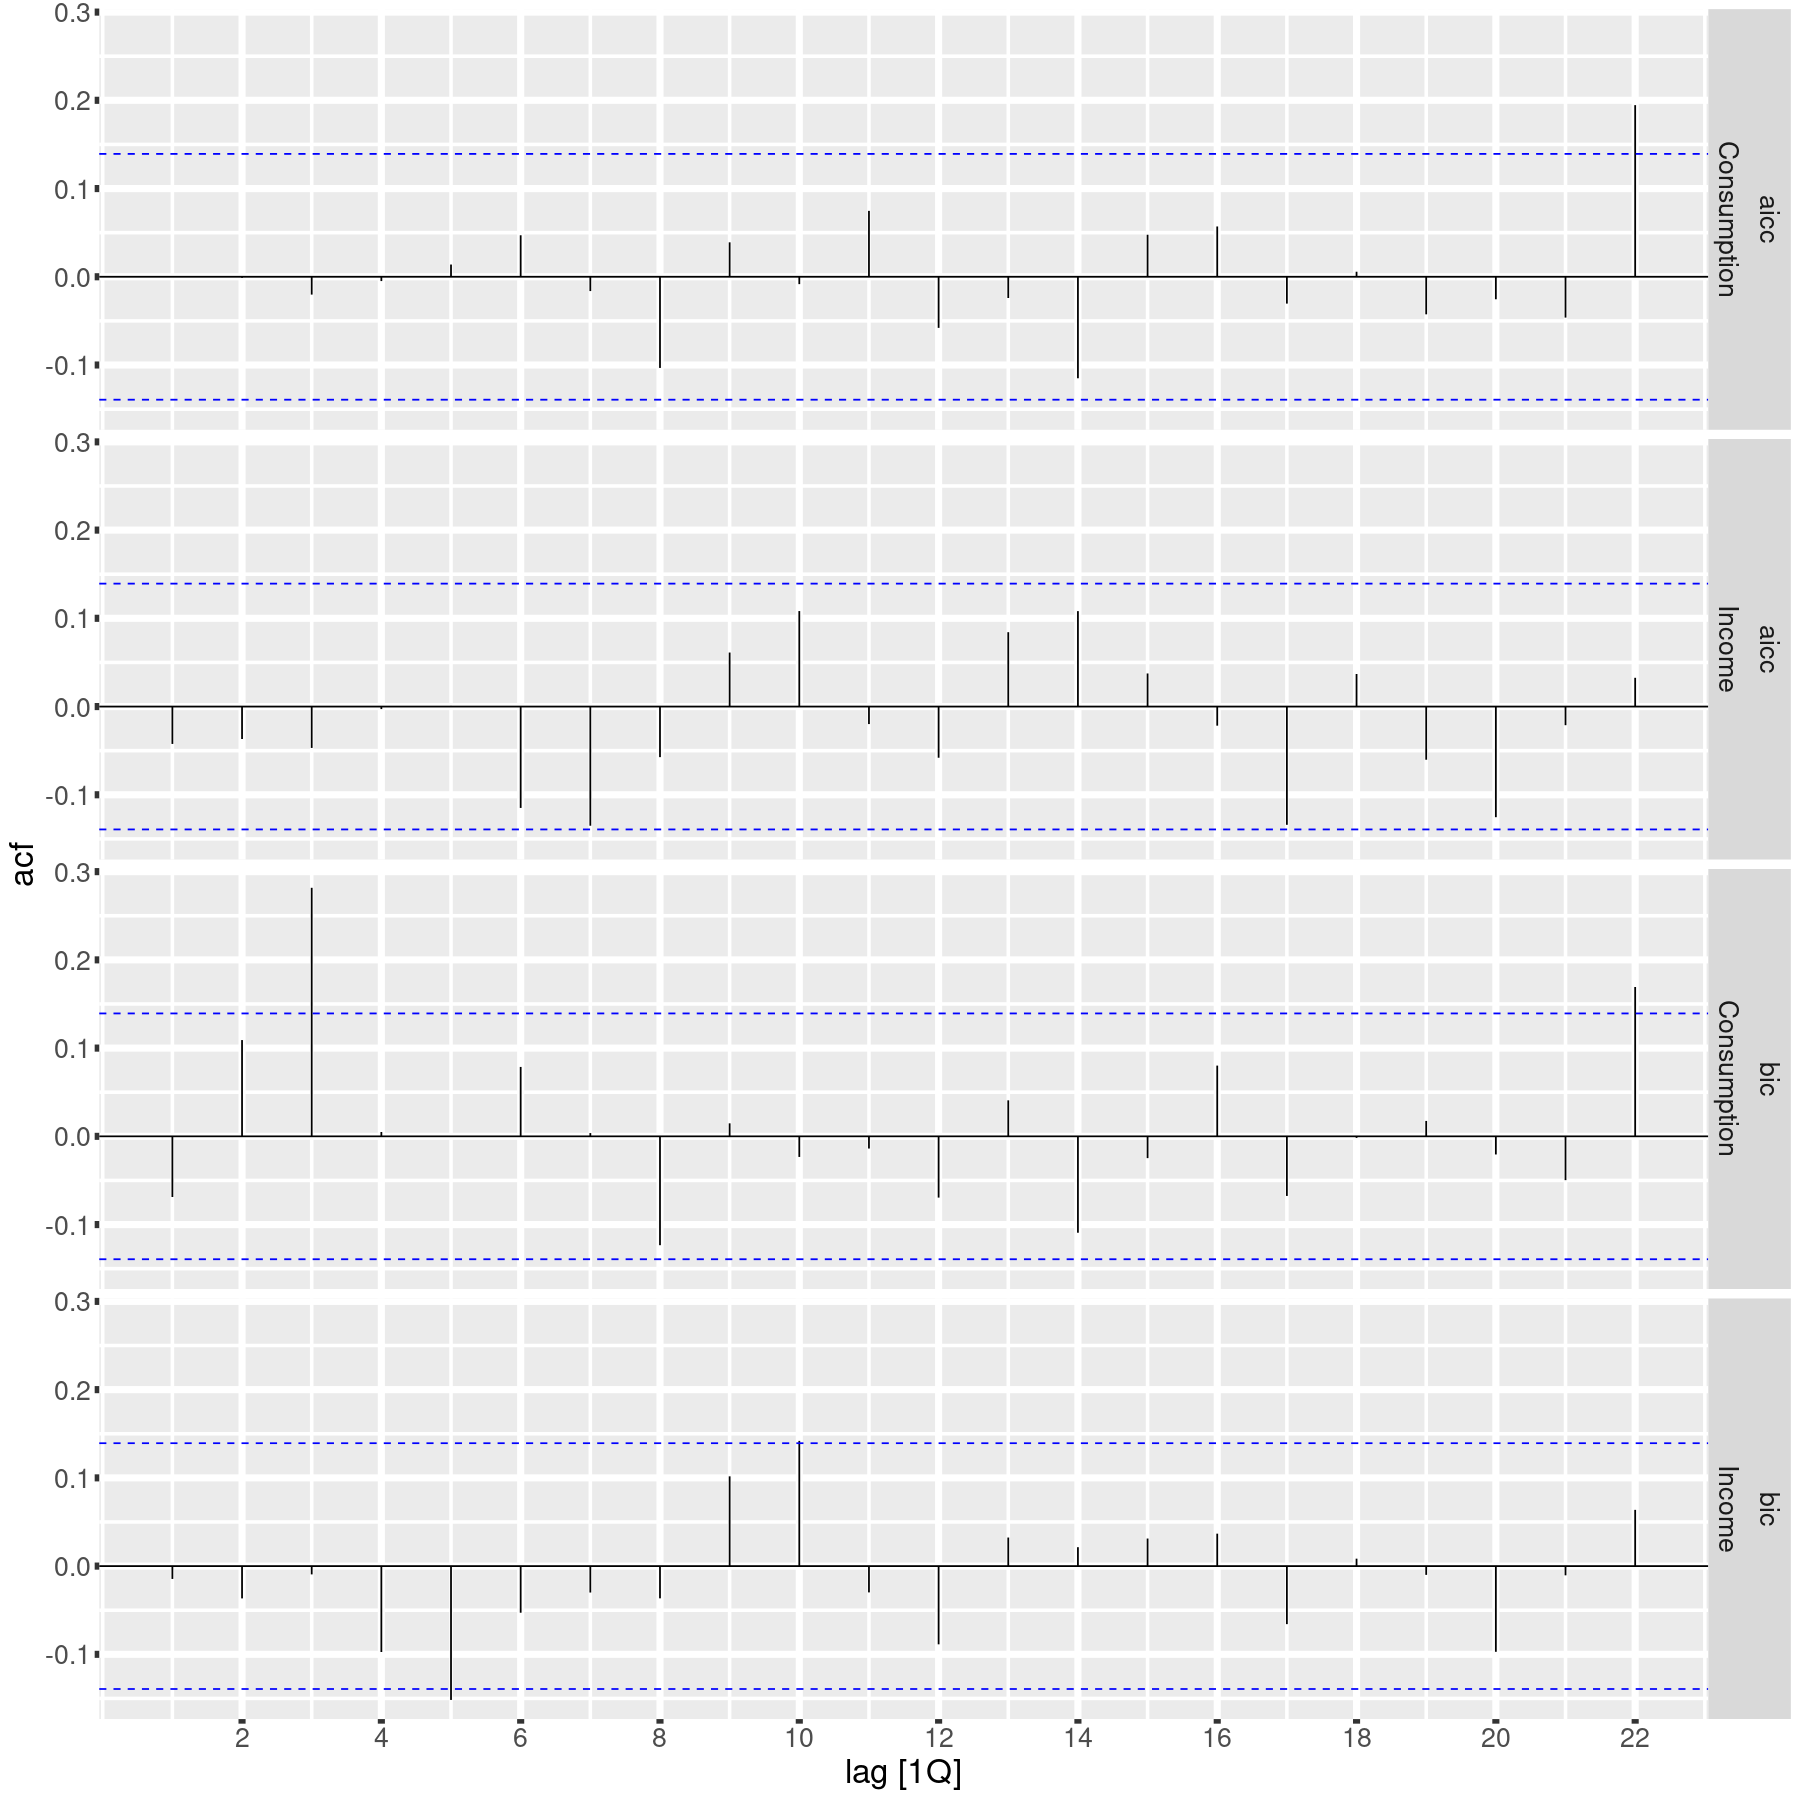

In [11]:
options(repr.plot.width=15, repr.plot.height=15)

fit |> augment() |> ACF(.innov) |> autoplot() + theme(text=element_text(size=20), element_line(size=2))

Previsões para o modelo VAR(5).

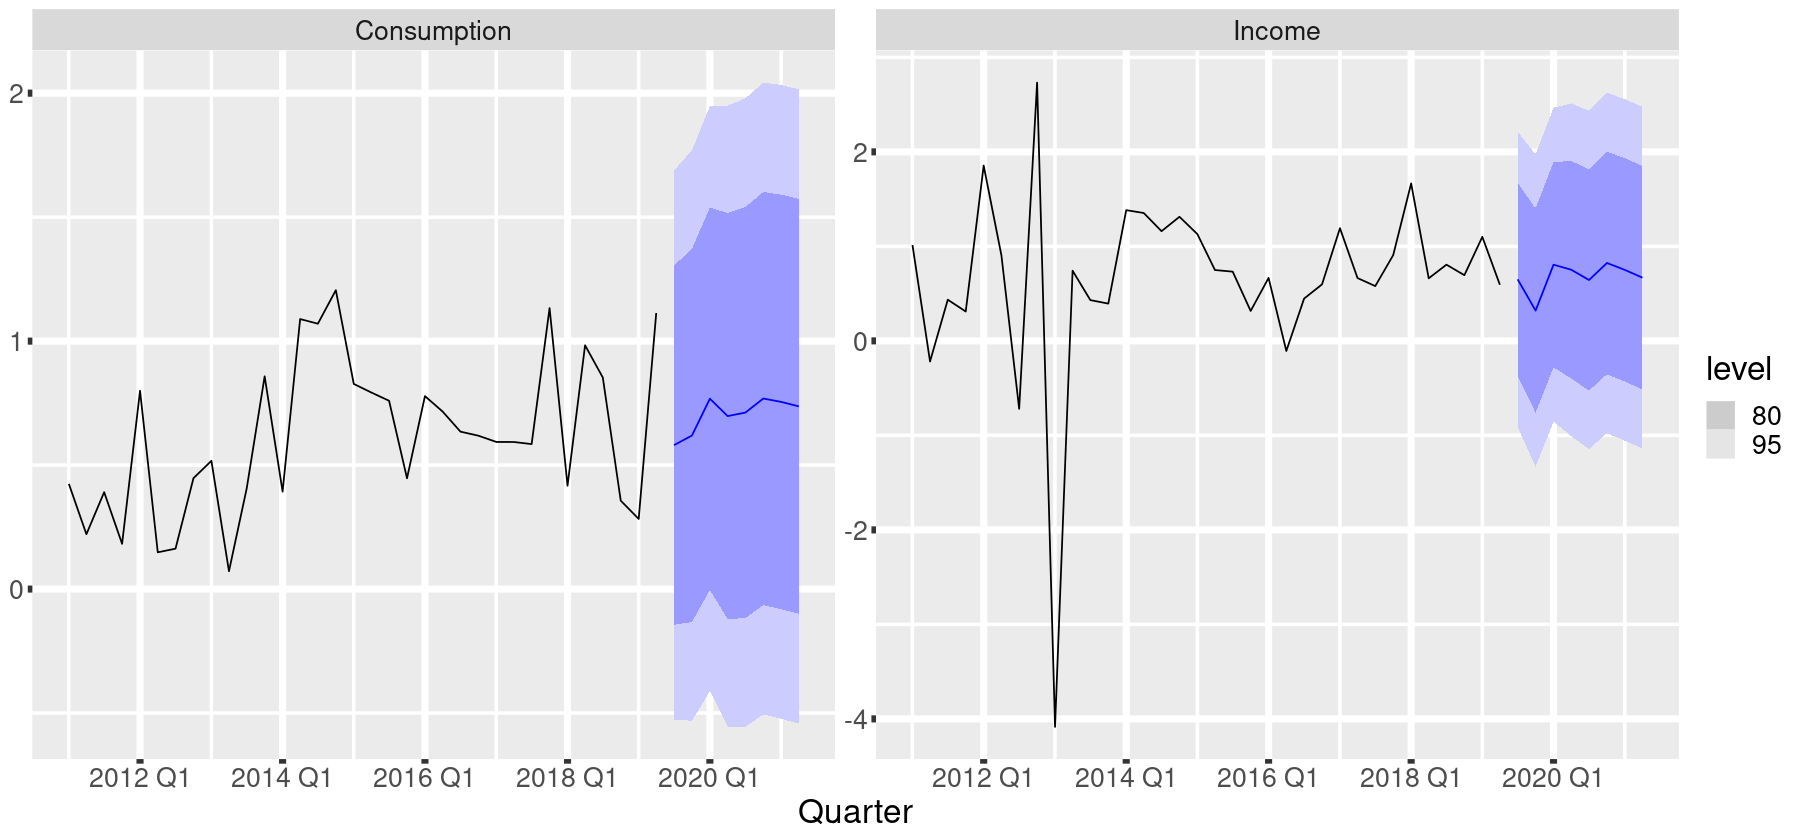

In [9]:
options(repr.plot.width=15, repr.plot.height=7)

fit |> select(aicc) |> forecast() |>
autoplot(us_change |> filter(year(Quarter) > 2010)) + theme(text=element_text(size=20), element_line(size=2))

Previsões para o modelo VAR(1).

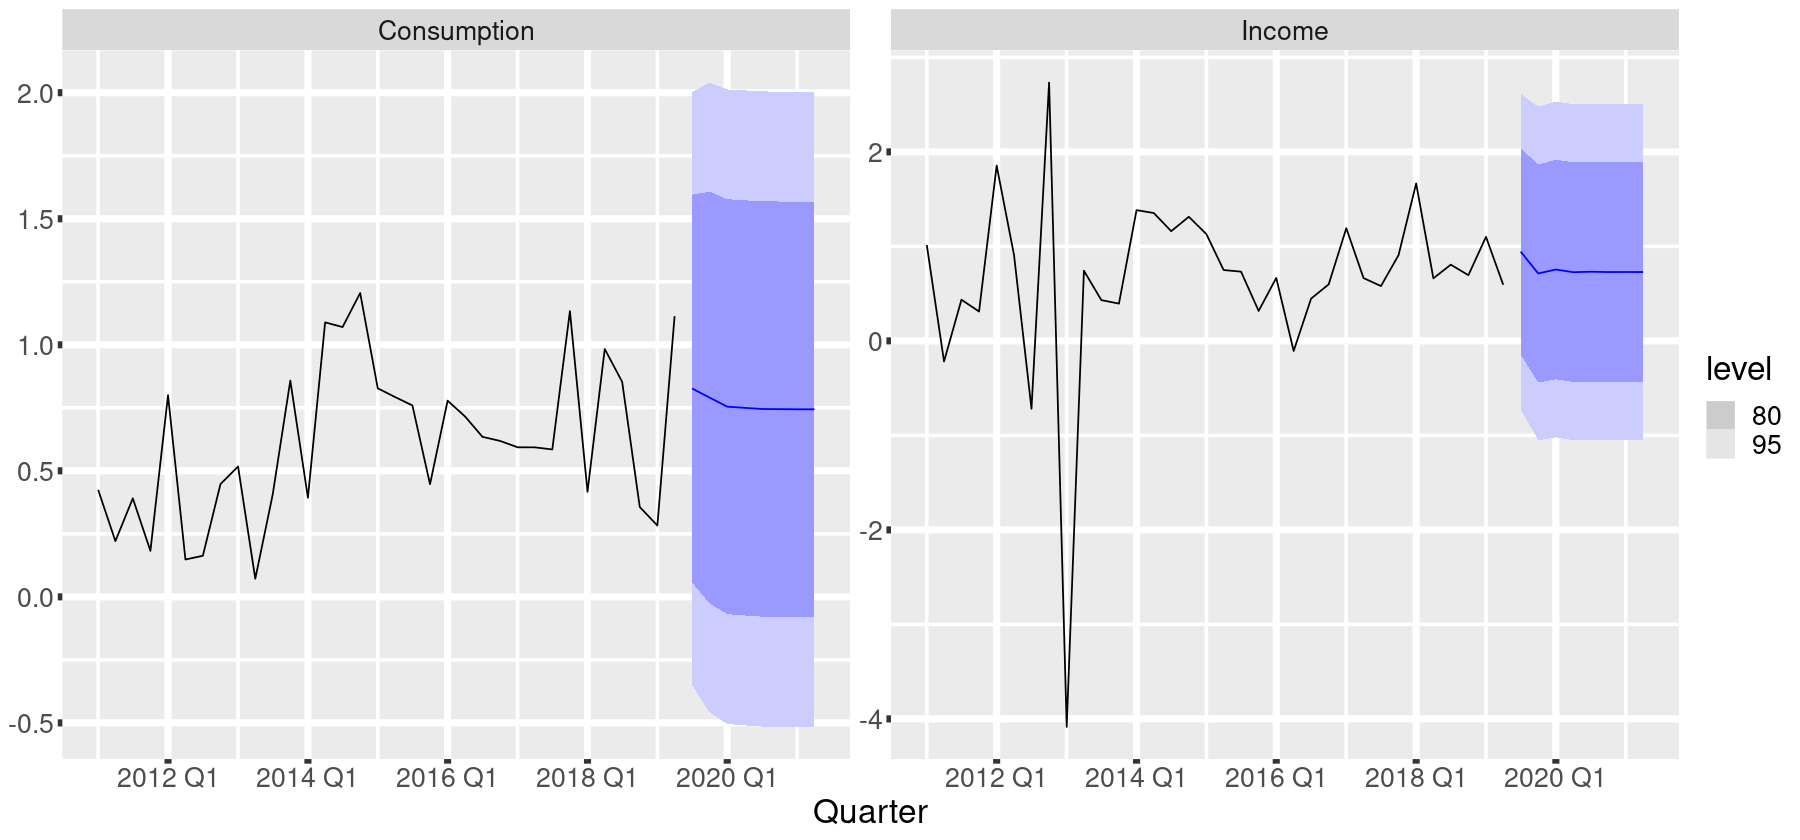

In [10]:
fit |> select(bic) |> forecast() |>
autoplot(us_change |> filter(year(Quarter) > 2010)) + theme(text=element_text(size=20), element_line(size=2))